### 数据探索

In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
from IPython.display import display

In [2]:
df_bids = pd.read_csv('bids.csv', low_memory=False)
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

In [3]:
df_bids.head()

,bid_id,bidder_id,auction,merchandise,device,time,country,ip,url
0,0,8dac2b259fd1c6d1120e519fb1ac14fbqvax8,ewmzr,jewelry,phone0,9759243157894736,us,69.166.231.58,vasstdc27m7nks3
1,1,668d393e858e8126275433046bbd35c6tywop,aeqok,furniture,phone1,9759243157894736,in,50.201.125.84,jmqlhflrzwuay9c
2,2,aa5f360084278b35d746fa6af3a7a1a5ra3xe,wa00e,home goods,phone2,9759243157894736,py,112.54.208.157,vasstdc27m7nks3
3,3,3939ac3ef7d472a59a9c5f893dd3e39fh9ofi,jefix,jewelry,phone4,9759243157894736,in,18.99.175.133,vasstdc27m7nks3
4,4,8393c48eaf4b8fa96886edc7cf27b372dsibi,jefix,jewelry,phone5,9759243157894736,in,145.138.5.37,vasstdc27m7nks3


In [4]:
df_train.head()
# df_train.dtypes

,bidder_id,payment_account,address,outcome
0,91a3c57b13234af24875c56fb7e2b2f4rb56a,a3d2de7675556553a5f08e4c88d2c228754av,a3d2de7675556553a5f08e4c88d2c228vt0u4,0.0
1,624f258b49e77713fc34034560f93fb3hu3jo,a3d2de7675556553a5f08e4c88d2c228v1sga,ae87054e5a97a8f840a3991d12611fdcrfbq3,0.0
2,1c5f4fc669099bfbfac515cd26997bd12ruaj,a3d2de7675556553a5f08e4c88d2c2280cybl,92520288b50f03907041887884ba49c0cl0pd,0.0
3,4bee9aba2abda51bf43d639013d6efe12iycd,51d80e233f7b6a7dfdee484a3c120f3b2ita8,4cb9717c8ad7e88a9a284989dd79b98dbevyi,0.0
4,4ab12bc61c82ddd9c2d65e60555808acqgos1,a3d2de7675556553a5f08e4c88d2c22857ddh,2a96c3ce94b3be921e0296097b88b56a7x1ji,0.0


### 异常数据检测

In [22]:
# 查看各表格中是否存在空值
print 'Is there any missing value in bids?',df_bids.isnull().any().any()
print 'Is there any missing value in train?',df_train.isnull().any().any()
print 'Is there any missing value in test?',df_test.isnull().any().any()

Is there any missing value in bids? True
Is there any missing value in train? False
Is there any missing value in test? False


整个对三个数据集进行空值判断，发现用户数据训练集和测试集均无缺失数据，而在竞标行为数据集中存在缺失值的情况，下面便针对bids数据进一步寻找缺失值

In [23]:
# nan_rows = df_bids[df_bids.isnull().T.any().T]
# print nan_rows
pd.isnull(df_bids).any()

bid_id         False
bidder_id      False
auction        False
merchandise    False
device         False
time           False
country         True
ip             False
url            False
dtype: bool

In [26]:
missing_country = df_bids['country'].isnull().sum().sum()
print 'No. of missing country: ', missing_country
normal_country = df_bids['country'].notnull().sum().sum()
print 'No. of normal country: ', normal_country

No. of missing country:  8859
No. of normal country:  7647475


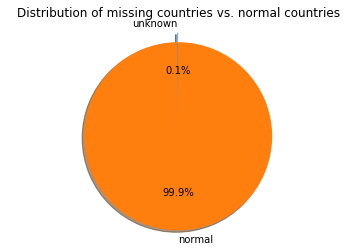

In [32]:
import matplotlib.pyplot as plt
labels = ['unknown', 'normal']
sizes = [missing_country, normal_country]
explode = (0.1, 0)
fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
ax1.axis('equal')
plt.title('Distribution of missing countries vs. normal countries')
plt.show()

综合上述的分析可以发现，在竞标行为用户的`country`一栏属性中存在很少一部分用户行为是没有`country`记录的，在预处理部分可以针对这部分缺失数据进行填充操作，有两种思路：
* 针对原始行为数据按照用户分组后，看看每个对应的用户竞标时经常所位于的国家信息，对缺失值填充常驻国家
* 针对原始行为数据按照用户分组后，按时间顺序对每组用户中的缺失值前向或后向填充相邻的国家信息

In [5]:
# 查看各个数据的记录数
# 看看数据的id是否是唯一标识
print df_bids.shape[0]
print len(df_bids['bid_id'].unique())
print df_train.shape[0]
print len(df_train['bidder_id'].unique())
print df_test.shape[0]
print len(df_test['bidder_id'].unique())

7656334
7656334
2013
2013
4700
4700


In [6]:
# 简单统计各项基本特征（类别特征）的数目（除去时间）
print 'total bidder in bids: ', len(df_bids['bidder_id'].unique())
print 'total auction in bids: ', len(df_bids['auction'].unique())
print 'total merchandise in bids: ', len(df_bids['merchandise'].unique())
print 'total device in bids: ', len(df_bids['device'].unique())
print 'total country in bids: ', len(df_bids['country'].unique())
print 'total ip in bids: ', len(df_bids['ip'].unique())
print 'total url in bids: ', len(df_bids['url'].unique())

total bidder in bids:  6614
total auction in bids:  15051
total merchandise in bids:  10
total device in bids:  7351
total country in bids:  200
total ip in bids:  2303991
total url in bids:  1786351


由上述基本特征可以看到：
* 竞标行为中的用户总数少于训练集+测试集的用户数，也就是说并不是一一对应的，接下来验证下竞标行为数据中的用户是否完全来自训练集和测试集
* 商品类别和国家的种类相对其他特征较少，可以作为天然的类别特征提取出来进行处理，而其余的特征可能更多的进行计数统计

In [7]:
lst_all_users = (df_train['bidder_id'].unique()).tolist() + (df_test['bidder_id'].unique()).tolist()
print 'total bidders of train and test set',len(lst_all_users)
lst_bidder = (df_bids['bidder_id'].unique()).tolist()
print 'total bidders in bids set',len(lst_bidder)
print 'Is bidders in bids are all from train+test set? ',set(lst_bidder).issubset(set(lst_all_users))

total bidders of train and test set 6713
total bidders in bids set 6614
Is bidders in bids are all from train+test set?  True


In [8]:
lst_nobids = [i for i in lst_all_users if i not in lst_bidder]
print 'No. of bidders never bid: ',len(lst_nobids)
lst_nobids_train = [i for i in lst_nobids if i in (df_train['bidder_id'].unique()).tolist()]
lst_nobids_test = [i for i in lst_nobids if i in (df_test['bidder_id'].unique()).tolist()]
print 'No. of bidders never bid in train set: ',len(lst_nobids_train)
print 'No. of bidders never bid in test set: ',len(lst_nobids_test)

No. of bidders never bid:  99
No. of bidders never bid in train set:  29
No. of bidders never bid in test set:  70


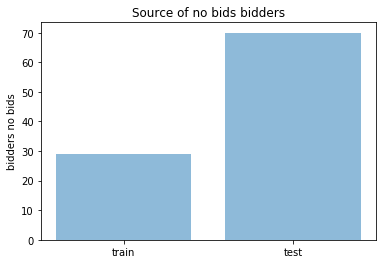

In [12]:
data_source = ['train', 'test']
y_pos = np.arange(len(data_source))
num_never_bids = [len(lst_nobids_train), len(lst_nobids_test)]
plt.bar(y_pos, num_never_bids, align='center', alpha=0.5)
plt.xticks(y_pos, data_source)
plt.ylabel('bidders no bids')
plt.title('Source of no bids bidders')
plt.show()

In [9]:
print df_train[(df_train['bidder_id'].isin(lst_nobids_train)) & (df_train['outcome']==1.0)]

Empty DataFrame
Columns: [bidder_id, payment_account, address, outcome]
Index: []


由上述计算可知存在99个竞标者无竞标记录，其中29位来自训练集，70位来自测试集，而且这29位来自训练集的竞标者未被标记为机器人用户，所以可以针对测试集中的这70位用户后续标记为人类或者取平均值处理

In [10]:
# check the partition of bots in train
print (df_train[df_train['outcome'] == 1].shape[0]*1.0) / df_train.shape[0] * 100,'%'

5.11674118231 %


训练集中的标记为机器人的用户占所有用户数目约5%

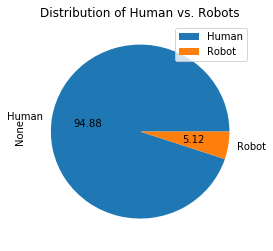

In [21]:
df_train.groupby('outcome').size().plot(labels=['Human', 'Robot'], kind='pie', autopct='%.2f', figsize=(4, 4), 
                                        title='Distribution of Human vs. Robots', legend=True)


由上述训练集中的正负例分布可以看到本数据集正负例比例失衡，所以后续考虑使用AUC（不受正负例比例影响）作为评价指标，此外尽量采用Gradient Boosting族模型来进行训练